In [118]:
import torch, os
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from torchvision import transforms, datasets
from torchviz import make_dot

### `data loader`

In [119]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform

        list_data = os.listdir(self.data_dir)

        list_label = [file for file in list_data if file.startswith('label')]
        list_input = [file for file in list_data if file.startswith('input')]

        list_label.sort()
        list_input.sort()

        self.list_label = list_label 
        self.list_input = list_input
        
    def __len__(self):
        return len(self.list_label)

    def __getitem__(self, idx):
        label = np.load(os.path.join(self.data_dir, self.list_label[idx]))
        input = np.load(os.path.join(self.data_dir, self.list_input[idx]))

        label = label / 255
        input = input / 255

        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input' : input, 'label' : label}

        if self.transform:
            data = self.transform(data)

        return data        

In [120]:
data_dir = 'C:\\Users\\admin\\Desktop\\workspace\\data file\\data'

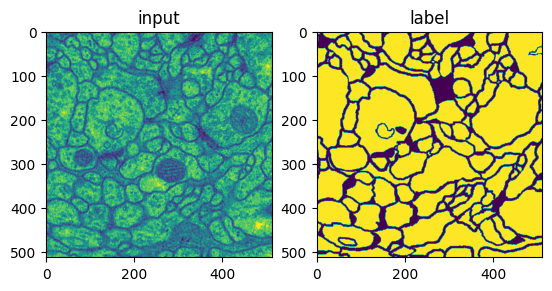

In [121]:
train = Dataset(data_dir = os.path.join(data_dir, 'train'))

dt =  train.__getitem__(0)

a = dt['input']
b = dt['label']

plt.subplot(121)
plt.imshow(a.squeeze())
plt.title('input')
plt.subplot(122)
plt.imshow(b.squeeze())
plt.title('label')
plt.show()

### `transform type`

In [122]:
class numtoten(object):
    def __call__(self, dic_data):
        label, input = dic_data['label'], dic_data['input']
        
        # img dim in numpy = (y, x, CH) , img dim in tensor = (CH, y, x)
        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)
                            # numpy to tensor
        data = {'label' : torch.from_numpy(label), 'input' : torch.from_numpy(input)}

        return data

class nomalizer(object):
    def __init__(self, mean = 0.5, std = 0.5):
        self.mean = mean
        self.std = std

    def __call__(self, dic_data):
        label, input = dic_data['label'], dic_data['input']
        input = (input - self.mean) / self.std
        dic_data = {'label' : label, 'input' : input}

        return dic_data

class ranflip(object):
    def __call__(self, dic_data):
        label, input = dic_data['label'], dic_data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        dic_data = {'label' : label, 'input' : input}

        return dic_data

### `u-net architecture` 

In [123]:
class unet(nn.Module): # nn.Module 상속
    def __init__(self):
        super(unet, self).__init__()

        def cv2d(input_channels, output_channels, kernel_size = 3, stride = 1, padding = 1, bias = True):
            layers = []
            layers += [nn.Conv2d(input_channels, output_channels,
                                 kernel_size = kernel_size, stride = stride, padding = padding, bias = bias)]
            layers += [nn.BatchNorm2d(num_features = output_channels)]
            layers += [nn.ReLU()]      

            cbr = nn.Sequential(*layers)

            return cbr
        
        # contract path
        
        self.enc1_1 = cv2d(1, 64)       
        self.enc1_2 = cv2d(64, 64)

        self.mxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.enc2_1 = cv2d(64, 128)
        self.enc2_2 = cv2d(128, 128)

        self.mxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.enc3_1 = cv2d(128, 256)
        self.enc3_2 = cv2d(256, 256)

        self.mxpool3 = nn.MaxPool2d(kernel_size = 2)

        self.enc4_1 = cv2d(256, 512)
        self.enc4_2 = cv2d(512, 512)

        self.mxpool4 = nn.MaxPool2d(kernel_size = 2)

        self.enc5_1 = cv2d(512, 1024)

        # expand path

        self.dec5_1 = cv2d(1024, 512)

        self.upconv4 = nn.ConvTranspose2d(512, 512,
                                         kernel_size = 2, stride = 2, padding = 0, bias = True)

        self.dec4_2 = cv2d(2 * 512, 512)                                
        self.dec4_1 = cv2d(512, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 256,
                                         kernel_size = 2, stride = 2, padding = 0, bias = True)  

        self.dec3_2 = cv2d(2 * 256, 256)                                                           
        self.dec3_1 = cv2d(256, 128)

        self.upconv2 = nn.ConvTranspose2d(128, 128,
                                          kernel_size = 2, stride = 2, padding = 0, bias = True) 

        self.dec2_2 = cv2d(2 * 128, 128)                                                           
        self.dec2_1 = cv2d(128, 64)                 

        self.upconv1 = nn.ConvTranspose2d(64, 64,
                                          kernel_size = 2, stride = 2, padding = 0, bias = True) 

        self.dec1_2 = cv2d(2 * 64, 64)                                                           
        self.dec1_1 = cv2d(64, 64)

        self.fc = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 1, stride = 1, padding = 0, bias = True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        enc_pool1 = self.mxpool1(enc1_2)

        enc2_1 = self.enc2_1(enc_pool1)
        enc2_2 = self.enc2_2(enc2_1)
        enc_pool2 = self.mxpool2(enc2_2)

        enc3_1 = self.enc3_1(enc_pool2)
        enc3_2 = self.enc3_2(enc3_1)
        enc_pool3 = self.mxpool3(enc3_2)

        enc4_1 = self.enc4_1(enc_pool3)
        enc4_2 = self.enc4_2(enc4_1)
        enc_pool4 = self.mxpool4(enc4_2)    

        enc5_1 = self.enc5_1(enc_pool4)   

        dec5_1 = self.dec5_1(enc5_1)
        
        dec_pool4 = self.upconv4(dec5_1)
        cat4 = torch.cat((dec_pool4, enc4_2), dim = 1)

        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        dec_pool3 = self.upconv3(dec4_1)
        cat3 = torch.cat((dec_pool3, enc3_2), dim = 1)
        dec3_2 = self.dec3_2(cat3)     
        dec3_1 = self.dec3_1(dec3_2) 

        dec_pool2 = self.upconv2(dec3_1)
        cat2 = torch.cat((dec_pool2, enc2_2), dim = 1)
        dec2_2 = self.dec2_2(cat2)     
        dec2_1 = self.dec2_1(dec2_2)   

        dec_pool1 = self.upconv1(dec2_1)
        cat1 = torch.cat((dec_pool1, enc1_2), dim = 1) # dim = 0 : 배치방향, 1 : 채널방향, 2 : y 방향, 3 : x 방향
        dec1_2 = self.dec1_2(cat1)     
        dec1_1 = self.dec1_1(dec1_2) 

        x = self.fc(dec1_1)  

        return x

In [129]:
lr = 1e-3
batch_size = 8
num_epoch = 10

ckpt_dir = './checkpoint'
log_dir = './log'

In [130]:
# apply to training data set (class = normalizer,  randflip, numtoten) 
transform = transforms.Compose([nomalizer(mean = 0.5, std = 0.5), ranflip(), numtoten()])

train_set = Dataset(data_dir = os.path.join(data_dir, 'train'),  transform = transform)
load_train = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 0)

val_set = Dataset(data_dir = os.path.join(data_dir, 'val'),  transform = transform)
load_val = DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 0)

# model = unet().to(device) .to(device) 네트워크가 gpu, cpu 어디서 학습하는지 확인.

# 모델
model = unet()

# 손실함수
fn_loss = nn.BCEWithLogitsLoss()

# 옵티마이저
opt = torch.optim.Adam(model.parameters(), lr = lr)

# 그 밖 변수들 설정
len_trian_set = len(train_set)
len_val_set = len(val_set)

len_batch_train = np.ceil(len_trian_set /batch_size) # batch_size
len_batch_val = np.ceil(len_val_set / batch_size)

# 그 밖 함수들 설정

# tensor -> numpy
fn_tentonum = lambda x : x.detach().numpy().transpose(0, 2, 3, 1)

# normalize data -> denormalize
fn_denorm = lambda x, mean, std : (x * std) + mean

# 네트워크 output 이미지들 binary 하게 분류 해주기
fn_class = lambda x : 1.0 * (x > 0.5)

# tensorboard 사용위해 summarywriter 설정
writer_train = SummaryWriter(log_dir = os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir, 'val'))

In [131]:
# 네트워크 저장
def save(ckpt_dir, model, opt, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({"net" : model.state_dict(), 'optimizer' : opt.state_dict()},
                "./%s/model_epoch%d.pth" % (ckpt_dir, epoch))

In [132]:
# 네트워크 불러오기
def load(ckpt_dir, model, opt):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return model, opt, epoch

    ckpt_list = os.listdir(ckpt_dir)
    ckpt_list.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('./%s/%s' % (ckpt_dir, ckpt_list[-1]))

    model.load_state_dict(dict_model['model'])
    opt.load_state_dict(dict_model['optimizer'])
    epoch = int(ckpt_list[-1].split('epoch')[1].split('.pth')[0])
    
    return model, opt, epoch 

In [133]:
_epoch = 0
model, opt, _epoch = load(ckpt_dir = ckpt_dir, model = model, opt = opt)

for epoch in range(_epoch + 1 , num_epoch + 1):
    model.train()
    loss_arr = []
    
    for batch, data in enumerate(load_train, 1):
        # forward pass
        label = data['label']
        input = data['input']

        output = model(input)

        # backward pass
        opt.zero_grad()

        loss = fn_loss(output, label)
        loss.backward()

        opt.step()

        # loss calculate
        loss_arr += [loss.item()]

        print(f"train: EPOCH {epoch} / {num_epoch} | batch {batch} / {int(len_trian_set/8)} | loss {np.mean(loss_arr)}")


        # tensorboard save
        label = fn_tentonum(label)
        input = fn_tentonum(fn_denorm(input, mean = 0.5, std = 0.5))
        output = fn_tentonum(fn_class(output))

        writer_train.add_image('label', label, len_batch_train * (epoch - 1) + batch, dataformats = 'NHWC')
        writer_train.add_image('input', input, len_batch_train * (epoch - 1) + batch, dataformats = 'NHWC')
        writer_train.add_image('output', output, len_batch_train * (epoch - 1) + batch, dataformats = 'NHWC')
    
    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    # validation 
    # backpropagation 막으려고 no_grad사용
    # with torch.no_grad():
    with torch.inference_mode():
        model.eval()
        loss_arr = []

        for batch, data in enumerate(load_val, 1):
            # forward pass
            label = data['label']
            input = data['input']
            output = model(input)

            # loss calculate
            loss = fn_loss(output, label)

            loss_arr += [loss.item()]

            print(f"valid: EPOCH {epoch} / {num_epoch} | batch {batch} / {1} | loss {np.mean(loss_arr)}")
                 # (epoch, num_epoch, batch_size, len_batch_val, np.mean(loss_arr)))

            # tensorboard 에 저장하기.
            label = fn_tentonum(label)
            input = fn_tentonum(fn_denorm(input, mean = 0.5, std = 0.5))
            output = fn_tentonum(fn_class(output))

            writer_val.add_image('label', label, len_batch_val * (epoch - 1) + batch, dataformats = 'NHWC')
            writer_val.add_image('input', input, len_batch_val * (epoch - 1) + batch, dataformats = 'NHWC')
            writer_val.add_image('output', output, len_batch_val * (epoch - 1) + batch, dataformats = 'NHWC')

    writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

    if epoch % 10 == 0:
        save(ckpt_dir = ckpt_dir, model = model, opt = opt, epoch = epoch)

writer_train.close()
writer_val.close()

train: EPOCH 1 / 10 | batch 1 / 3 | loss 0.7623306512832642
train: EPOCH 1 / 10 | batch 2 / 3 | loss 0.703286349773407
train: EPOCH 1 / 10 | batch 3 / 3 | loss 0.6707384983698527
valid: EPOCH 1 / 10 | batch 1 / 1 | loss 0.6560941338539124
train: EPOCH 2 / 10 | batch 1 / 3 | loss 0.5581104755401611
train: EPOCH 2 / 10 | batch 2 / 3 | loss 0.5295895040035248
train: EPOCH 2 / 10 | batch 3 / 3 | loss 0.5191793044408163
valid: EPOCH 2 / 10 | batch 1 / 1 | loss 0.6065900325775146
train: EPOCH 3 / 10 | batch 1 / 3 | loss 0.45692259073257446
train: EPOCH 3 / 10 | batch 2 / 3 | loss 0.4570681154727936
train: EPOCH 3 / 10 | batch 3 / 3 | loss 0.4484294652938843
valid: EPOCH 3 / 10 | batch 1 / 1 | loss 0.5263785123825073
train: EPOCH 4 / 10 | batch 1 / 3 | loss 0.4206792712211609
train: EPOCH 4 / 10 | batch 2 / 3 | loss 0.4112967401742935
train: EPOCH 4 / 10 | batch 3 / 3 | loss 0.4052218596140544
valid: EPOCH 4 / 10 | batch 1 / 1 | loss 0.4623969495296478
train: EPOCH 5 / 10 | batch 1 / 3 | loss

In [134]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### `tensorboard`

<img src = 'https://drive.google.com/uc?id=1EaAx-N53tkGV9QdhnMyDW9fwkDQv3u9u' height = 600 width = 1200>